In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
my_path = '/content/gdrive/My Drive/Data-Science-Google-Colab/'

In [ ]:
cd $my_path

/content/gdrive/My Drive/Data-Science-Google-Colab


In [ ]:
cd face_detection/

/content/gdrive/My Drive/Data-Science-Google-Colab/face_detection


In [ ]:
ls

bbox_train.csv                       mtcnn-submission.csv  vgg16-1.csv
haarcascade_frontalface_default.xml  submission.csv        vgg16-2.csv
image_data/                          test.csv
models/                              train.csv


In [ ]:
images_dir = my_path+'face_detection/image_data/'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
df = pd.read_csv('train.csv')
df

,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4
...,...,...
5728,18201.jpg,2
5729,18203.jpg,3
5730,18204.jpg,5
5731,18205.jpg,8


In [ ]:
# # incase you want to find time of execution
# start_time = time.time()
# plt.imread(images_dir+'10001.jpg')
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def process_image(img):
    dim = (224,224)
    # reading with plt is a bit faster
    img = plt.imread(img)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_LINEAR)
    if img.shape!=(224,224,3):
      img = np.stack([img]*3, axis=-1)
    # if img.shape==(224,224,3):
      # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = np.reshape(img, (224,224,1))
    return img


In [ ]:
X = []
y = []
images = df.Name
hc = df.HeadCount

for i,img in enumerate(images):
  try:
    image = process_image(images_dir+img)
  except:
    continue
  # if image.shape!=(224, 224, 3):
  #   continue
  X.append(image)
  y.append(hc[i])

In [ ]:
for i in range(len(X)):
  if X[i].shape!=(224,224,3):
    # X[i] = np.stack([X[45]]*3, axis=-1)
    print(i, X[i].shape)

In [ ]:
len(X), len(y)

(5732, 5732)

In [ ]:
X = np.array(X)
X = X/255
y = np.array(y)

In [ ]:
del images
del hc
del df

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,InputLayer
from keras.applications.vgg16 import VGG16


input_shape = (224,224,3)
vgg = Sequential()
vgg.add(InputLayer(input_shape=input_shape))
for layer in VGG16().layers[:-3]:
  # Try fitting model by commenting below line and see the difference
  layer.trainable = False
  vgg.add(layer)
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dense(1, activation='linear'))

Using TensorFlow backend.


553467904/553467096 [==============================] - 7s 0us/step


In [ ]:
# vgg.summary()

In [ ]:
# from keras.optimizers import SGD
vgg.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])

In [ ]:
vgg.fit(X, y,epochs=13)

Epoch 1/2
5732/5732 [==============================] - 77s 13ms/step - loss: 0.0633 - mse: 0.0633
Epoch 2/2
5732/5732 [==============================] - 76s 13ms/step - loss: 0.0809 - mse: 0.0809


[[3.9599814]] 4


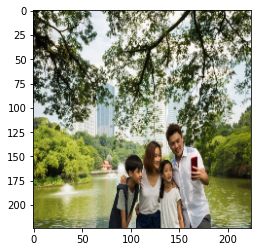

In [ ]:
i = 2505
p = vgg.predict(np.array([X[i]]))
plt.imshow(X[i])
print(p, y[i])

In [ ]:
df[df.HeadCount>10]

,Name,HeadCount
35,10054.jpg,11
123,10184.jpg,21
172,10257.jpg,13
195,10290.jpg,14
212,10320.jpg,15
...,...,...
5308,17587.jpg,12
5392,17712.jpg,14
5418,17748.jpg,20
5487,17853.jpg,11


[[2.9011154]] 3


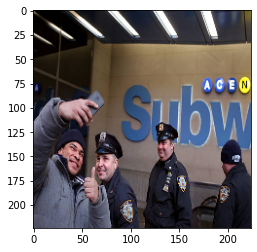

In [ ]:
i = 4101
p = vgg.predict(np.array([X[i]]))
plt.imshow(X[i])
print(p, y[i])

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test_X = []
for img in test.Name:
    image = process_image(images_dir+img)
    test_X.append(image)

In [ ]:
len(test_X), len(test.Name)

(2463, 2463)

In [ ]:
test_X = np.array(test_X)
test_X = test_X/255
test_X.shape

(2463, 224, 224, 3)

In [ ]:
preds = vgg.predict(test_X)

In [ ]:
preds = np.reshape(preds, (2463,))

In [ ]:
# preds = np.round(preds)

3.0


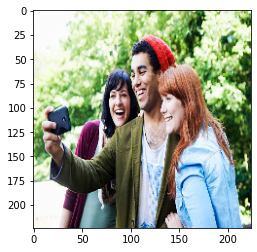

In [ ]:
i=254
plt.imshow(test_X[i])
print(preds[i])

In [ ]:
model_json = vgg.to_json()
with open("vgg16-3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
vgg.save_weights("vgg16-3.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
pd.DataFrame({'Name':test.Name, 'HeadCount':preds}).to_csv('vgg16-3.csv', index=False)

In [ ]:
# from google.colab import files
# files.download('vgg16-3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pd.read_csv('vgg16-3.csv')

,Name,HeadCount
0,10005.jpg,2.562949
1,10009.jpg,4.597756
2,10015.jpg,3.583119
3,10022.jpg,2.786866
4,10023.jpg,2.432540
...,...,...
2458,18197.jpg,3.011445
2459,18198.jpg,10.342514
2460,18199.jpg,2.437033
2461,18202.jpg,4.876488


In [ ]:
# !wget https://c0.thejournal.ie/media/2015/01/shutterstock_204448075-2-390x285.jpg

--2020-07-07 19:16:10--  https://c0.thejournal.ie/media/2015/01/shutterstock_204448075-2-390x285.jpg
Resolving c0.thejournal.ie (c0.thejournal.ie)... 104.16.134.32, 104.16.133.32, 2606:4700::6810:8520, ...
Connecting to c0.thejournal.ie (c0.thejournal.ie)|104.16.134.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33663 (33K) [image/jpeg]
Saving to: ‘shutterstock_204448075-2-390x285.jpg’

shutterstock_204448 100%[===================>]  32.87K  --.-KB/s    in 0.005s  

2020-07-07 19:16:11 (5.92 MB/s) - ‘shutterstock_204448075-2-390x285.jpg’ saved [33663/33663]



[[3.6569617]]


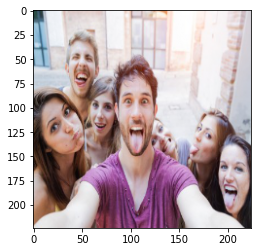

In [ ]:
img = process_image('shutterstock_204448075-2-390x285.jpg')
img = img/255
p = vgg.predict(np.array([img]))
print(p)
plt.imshow(img)

In [ ]:
# !wget https://www.irishtimes.com/polopoly_fs/1.3566968.1531756770!/image/image.jpg_gen/derivatives/box_620_330/image.jpg

--2020-07-07 19:18:52--  https://www.irishtimes.com/polopoly_fs/1.3566968.1531756770!/image/image.jpg_gen/derivatives/box_620_330/image.jpg
Resolving www.irishtimes.com (www.irishtimes.com)... 151.101.2.174, 151.101.66.174, 151.101.130.174, ...
Connecting to www.irishtimes.com (www.irishtimes.com)|151.101.2.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42339 (41K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  41.35K  --.-KB/s    in 0.02s   

2020-07-07 19:18:52 (2.51 MB/s) - ‘image.jpg’ saved [42339/42339]



[[11.332676]]


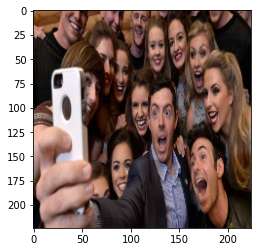

In [ ]:
img = process_image('image.jpg')
img = img/255
p = vgg.predict(np.array([img]))
print(p)
plt.imshow(img)

In [ ]:
del vgg

In [ ]:
from keras.applications import ResNet50
resnet_50 = ResNet50()

102858752/102853048 [==============================] - 2s 0us/step


In [ ]:
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,InputLayer
from keras.applications import ResNet50


input_shape = (224,224,3)
res = Sequential()
# res.add(InputLayer(input_shape=input_shape))
# for layer in ResNet50().layers[:-1]:
#   # Try fitting model by commenting below line and see the difference
#   layer.trainable = False
#   res.add(layer)
res.add(ResNet50(include_top = False, pooling = 'avg'))
res.add(Dense(4096, activation='relu'))
res.add(Dense(1, activation='linear'))
res.layers[0].trainable = False

94658560/94653016 [==============================] - 1s 0us/step


In [ ]:
res.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4097      
Total params: 31,984,513
Trainable params: 8,396,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
res.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])

In [ ]:
res.fit(X, y, epochs=10)

Epoch 1/10
5732/5732 [==============================] - 61s 11ms/step - loss: 0.9412 - mse: 0.9412
Epoch 2/10
5732/5732 [==============================] - 61s 11ms/step - loss: 0.8887 - mse: 0.8887
Epoch 3/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.7985 - mse: 0.7985
Epoch 4/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.7549 - mse: 0.7549
Epoch 5/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.6773 - mse: 0.6773
Epoch 6/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.7025 - mse: 0.7025
Epoch 7/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.7564 - mse: 0.7564
Epoch 8/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.8426 - mse: 0.8426
Epoch 9/10
5732/5732 [==============================] - 60s 11ms/step - loss: 0.8176 - mse: 0.8176
Epoch 10/10
5732/5732 [==============================] - 61s 11ms/step - loss: 0.6792 - mse: 0.6792


In [ ]:
res.layers[0].summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

7 [[3.0040143]]


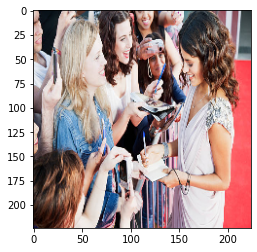

In [ ]:
i=106
p = res.predict(np.array([X[i]]))
print(y[i], p)
plt.imshow(X[i])

[[3.0870593]]


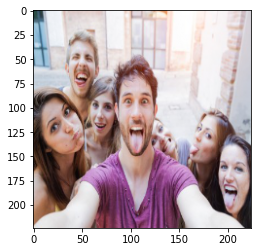

In [ ]:
img = process_image('shutterstock_204448075-2-390x285.jpg')
img = img/255
p = res.predict(np.array([img]))
print(p)
plt.imshow(img)

[[3.1839752]]


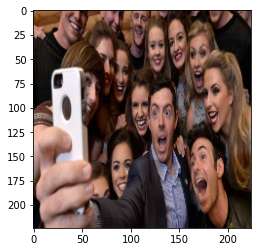

In [ ]:
img = process_image('image.jpg')
img = img/255
p = res.predict(np.array([img]))
print(p)
plt.imshow(img)

In [ ]:
from keras.models import Model
res_model = ResNet50()
model = Model(inputs=res_model.inputs, outputs=res_model.layers[-2].output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________